<a href="https://colab.research.google.com/github/87tana/NLP_SentimentAnalysis/blob/main/NLP_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE # dim redu

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

import pickle

In [4]:
# Step 1: Read the CSV file into a DataFrame
#df = pd.read_csv('C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis/processed_df.csv')
df = pd.read_csv(r"drive/MyDrive/NLP/processed_df.csv")

# Step 2: Remove rows with missing values (NaN)
# Comment: One row is empty, so we will drop it
df = df.dropna(axis=0)

# Step 3: Randomly sample 100,000 points for analysis
# Comment: Sampling 100k points
df = df.sample(100000, random_state=42)

# Step 4: Convert the 'Time' column to datetime format
# Comment: Converting time column to datetime format (assuming time is in seconds)
df['Time'] = pd.to_datetime(df['Time'], unit='s')

# Step 5: Sort the DataFrame based on the 'Time' column
# Comment: Sorting based on time
df = df.sort_values('Time')

# Step 6: Reset the index of the DataFrame for a clean index
df = df.reset_index(drop=True)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Time        100000 non-null  datetime64[ns]
 1   clean_text  100000 non-null  object        
 2   Score       100000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.3+ MB


In [6]:
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame with 'clean_text' and 'Score' columns
X = df['clean_text']
y = df['Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object
bow = CountVectorizer(max_features=5000) #The choice of the value for max_features depends on the size of your dataset,

# Fit and transform the training data
X_train_bow = bow.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_bow = bow.transform(X_test)

print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (80000, 5000)
shape of X_test_bow is (20000, 5000)


In [8]:
%%time
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Create Logistic Regression model
logreg = LogisticRegression(solver='liblinear',max_iter=1000)

# Create GridSearchCV object
model = GridSearchCV(logreg, param_grid, cv=5, return_train_score=True, scoring='f1_macro')
model.fit(X_train_bow, y_train)

# Print the best parameters
print("Model with best parameters:\n", model.best_params_)

Model with best parameters:
 {'C': 1, 'penalty': 'l1'}
CPU times: user 52min 49s, sys: 4.59 s, total: 52min 54s
Wall time: 53min 9s


In [ ]:
# check the performance on test set

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

# Use the best model to make predictions on the test set
y_pred = model.predict(X_test_bow)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           1       0.61      0.55      0.58      1813
           2       0.30      0.13      0.18      1080
           3       0.37      0.20      0.26      1484
           4       0.40      0.20      0.26      2805
           5       0.77      0.94      0.85     12818

    accuracy                           0.70     20000
   macro avg       0.49      0.40      0.43     20000
weighted avg       0.65      0.70      0.66     20000

Confusion Matrix:
 [[  995   112   100    65   541]
 [  244   140   145   102   449]
 [  154   118   296   262   654]
 [   81    44   141   554  1985]
 [  152    58   112   414 12082]]


- The model has an overall accuracy of 70%, meaning it correctly predicts the class for 70% of the instances.
- It performs well on Class 5, the majority class, with a high precision of 77% and recall of 94%.
-However, the model has challenges with minority classes (Classes 2, 3, and 4), where precision and recall are lower.

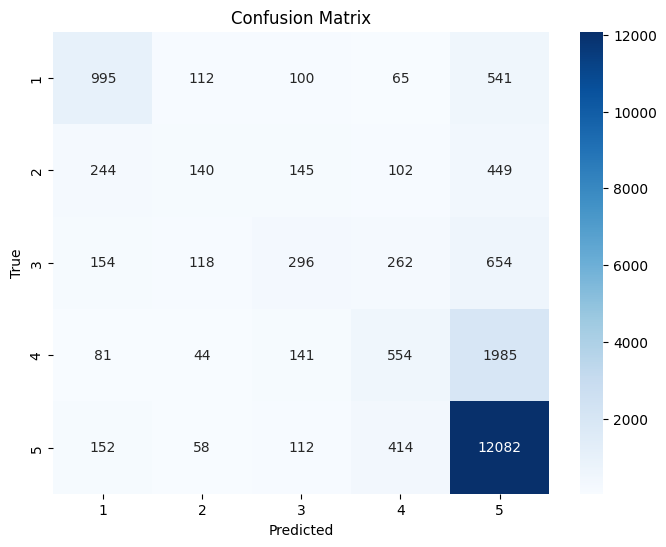

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


These metrics provide a detailed understanding of the model's performance for each class, considering precision, recall, and F1-score. Class 5 shows particularly high precision, recall, and F1-score, indicating good performance. Classes 2, 3, and 4 exhibit lower scores, suggesting challenges in correctly predicting instances for these classes.

 In scenarios with imbalanced classes, it's crucial to consider metrics like precision, recall, and F1-score, as accuracy alone might be misleading. The model appears to perform well in identifying Class 5 instances due to its higher support, but there's room for improvement in the prediction of other classes, especially those with lower support.

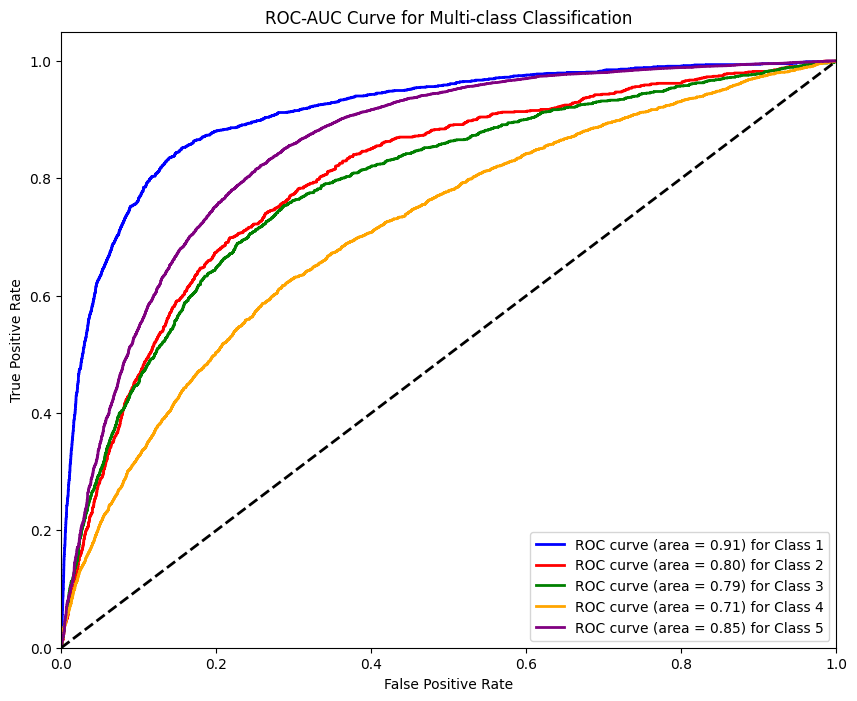

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Binarize the labels
y_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])

# Learn to predict each class against the other
classifier = OneVsRestClassifier(model.best_estimator_)

# Predict probabilities
y_score = classifier.fit(X_train_bow, y_train).predict_proba(X_test_bow)

# Compute ROC curve and ROC-AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {:.2f}) for Class {}'.format(roc_auc[i], i + 1))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()
